In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam
import augmentation
from ssd_loss import CustomLoss
from utils import bbox_utils, data_utils, io_utils, train_utils
from tensorflow_datasets import show_examples

In [2]:
#Hyper-parameters
batch_size = 10
epochs = 150
load_weights = False
backbone = "vgg16"
io_utils.is_valid_backbone(backbone)

In [3]:
#
if backbone == "mobilenet_v2":
    from models.ssd_mobilenet_v2 import get_model, init_model
else:
    from models.ssd_vgg16 import get_model, init_model
#
hyper_params = train_utils.get_hyper_params(backbone)
hyper_params

{'img_size': 300,
 'feature_map_shapes': [38, 19, 10, 5, 3, 1],
 'aspect_ratios': [[1.0, 2.0, 0.5],
  [1.0, 2.0, 0.5, 3.0, 0.3333333333333333],
  [1.0, 2.0, 0.5, 3.0, 0.3333333333333333],
  [1.0, 2.0, 0.5, 3.0, 0.3333333333333333],
  [1.0, 2.0, 0.5],
  [1.0, 2.0, 0.5]],
 'iou_threshold': 0.5,
 'neg_pos_ratio': 3,
 'loc_loss_alpha': 1,
 'variances': [0.1, 0.1, 0.2, 0.2]}

In [4]:
#load train/validation data VOC2007
train_data, info = data_utils.get_dataset("voc/2007", "train")
val_data, _ = data_utils.get_dataset("voc/2007", "validation")
train_total_items = data_utils.get_total_item_size(info, "train")
val_total_items = data_utils.get_total_item_size(info, "validation")

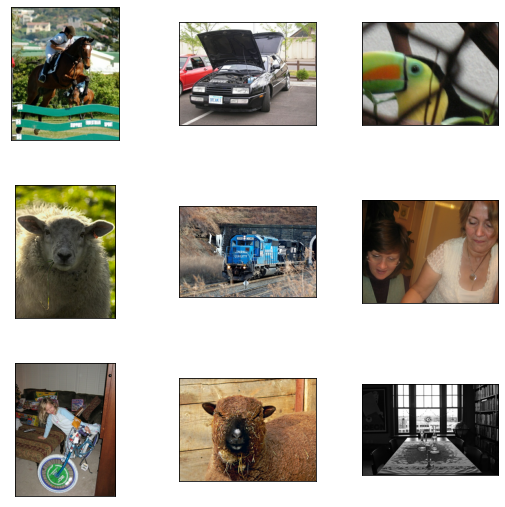

In [5]:
#Visualize data
fig = show_examples(train_data, info)

In [6]:
#load labels
labels = data_utils.get_labels(info)
labels = ["bg"] + labels
hyper_params["total_labels"] = len(labels)
img_size = hyper_params["img_size"]
labels,img_size

(['bg',
  'aeroplane',
  'bicycle',
  'bird',
  'boat',
  'bottle',
  'bus',
  'car',
  'cat',
  'chair',
  'cow',
  'diningtable',
  'dog',
  'horse',
  'motorbike',
  'person',
  'pottedplant',
  'sheep',
  'sofa',
  'train',
  'tvmonitor'],
 300)

In [7]:
#preprocessing images
train_data = train_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size, augmentation.apply))
val_data = val_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))
#Reshape
data_shapes = data_utils.get_data_shapes()
padding_values = data_utils.get_padding_values()
train_data = train_data.shuffle(batch_size*4).padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)
val_data = val_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)

In [8]:
#init model
ssd_model = get_model(hyper_params)
ssd_custom_losses = CustomLoss(hyper_params["neg_pos_ratio"], hyper_params["loc_loss_alpha"])
ssd_model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=[ssd_custom_losses.loc_loss_fn, ssd_custom_losses.conf_loss_fn])
init_model(ssd_model)

In [9]:
#Load weight?
ssd_model_path = io_utils.get_model_path(backbone)
if load_weights:
    ssd_model.load_weights(ssd_model_path)
ssd_log_path = io_utils.get_log_path(backbone)
# We calculate prior boxes
prior_boxes = bbox_utils.generate_prior_boxes(hyper_params["feature_map_shapes"], hyper_params["aspect_ratios"])
ssd_train_feed = train_utils.generator(train_data, prior_boxes, hyper_params)
ssd_val_feed = train_utils.generator(val_data, prior_boxes, hyper_params)

In [10]:
#training callbacks for Tensorboards and Saving
checkpoint_callback = ModelCheckpoint(ssd_model_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
tensorboard_callback = TensorBoard(log_dir=ssd_log_path)
learning_rate_callback = LearningRateScheduler(train_utils.scheduler, verbose=0)

In [11]:
#train
step_size_train = train_utils.get_step_size(train_total_items, batch_size)
step_size_val = train_utils.get_step_size(val_total_items, batch_size)
ssd_model.fit(ssd_train_feed,
              steps_per_epoch=step_size_train,
              validation_data=ssd_val_feed,
              validation_steps=step_size_val,
              epochs=epochs,
              callbacks=[checkpoint_callback, tensorboard_callback, learning_rate_callback])

Epoch 1/150
 81/251 [========>.....................] - ETA: 1:57 - loss: 13.7931 - loc_loss: 2.8906 - conf_loss: 8.5132